# Importing modules and functions

In [137]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import chembl_structure_pipeline
from molvs import standardize_smiles
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import joblib
import pickle
import matplotlib.pyplot as plt
from numpy import savetxt
from IPython.display import HTML
from rdkit.Chem import PandasTools

In [9]:
def convert_smi_to_canon_smi(smi):
    
    try:
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi),isomericSmiles = False)
    except:
        canon_smi='wrong_smiles'
    return canon_smi

In [8]:
def standart(smi):
    global m
    if smi!='wrong_smiles':
        try:
            smiles=standardize_smiles(smi)
            m = Chem.MolFromSmiles(smi)
        except:
            smi='error kekule'
    else:
        m = 'check the smiles'
    return m

# MORGAN FP_Gradient Boosting Mouse intravenous LD50, mg/kg  

## Load data and curation work set

In [3]:
# Set file path
df_ws=pd.read_csv('mouse_intravenous_LD50_WS.csv')
df_ws

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,67-56-1,CO,0.83270,4707.7000
1,19491-72-6,CCCNCC(Br)c1ccccc1,0.89274,30857.5000
2,64790-46-1,CN1C2CCC1CC(OC(=O)C(=O)c1ccccc1)C2,0.90777,33776.0000
3,34758-84-4,COC(CN1CCN(CC(O)C(OC)c2ccccc2)CC1)c1ccccc1,0.93852,44268.0000
4,9005-66-7,CCCCCCCCCCCC(=O)OCCOCC(OCCO)C1OCC(OCCO)C1OCCO,1.01926,49968.0000
...,...,...,...,...
12049,115722-23-1,CCC(C)C(NC(=O)C(N)CC(C)C)C(=O)N1CCCC1C(=O)N1CC...,7.35180,0.0400
12050,4026-95-3,CC12CCC(O)CC1CCC1C2CCC2(C)C(c3ccc(=O)oc3)C(O)C...,7.42650,0.0150
12051,465-19-0,CC12CCC(O)CC1CCC1C2CCC2(C)C(c3ccc(=O)oc3)C(O)C...,7.60480,0.0100
12052,35523-89-8,NC(=O)OCC1N=C(N)N2CCC(O)(O)C23NC(N)=NC13,7.74560,0.0054


 Convert a SMILES string to canonical SMILES

In [4]:
df_ws1 = deepcopy(df_ws)
df_ws1["SMILES"] = df_ws1.apply(lambda x: convert_smi_to_canon_smi(x.SMILES), axis=1)
df_ws1

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,67-56-1,CO,0.83270,4707.7000
1,19491-72-6,CCCNCC(Br)c1ccccc1,0.89274,30857.5000
2,64790-46-1,CN1C2CCC1CC(OC(=O)C(=O)c1ccccc1)C2,0.90777,33776.0000
3,34758-84-4,COC(CN1CCN(CC(O)C(OC)c2ccccc2)CC1)c1ccccc1,0.93852,44268.0000
4,9005-66-7,CCCCCCCCCCCC(=O)OCCOCC(OCCO)C1OCC(OCCO)C1OCCO,1.01926,49968.0000
...,...,...,...,...
12049,115722-23-1,CCC(C)C(NC(=O)C(N)CC(C)C)C(=O)N1CCCC1C(=O)N1CC...,7.35180,0.0400
12050,4026-95-3,CC12CCC(O)CC1CCC1C2CCC2(C)C(c3ccc(=O)oc3)C(O)C...,7.42650,0.0150
12051,465-19-0,CC12CCC(O)CC1CCC1C2CCC2(C)C(c3ccc(=O)oc3)C(O)C...,7.60480,0.0100
12052,35523-89-8,NC(=O)OCC1N=C(N)N2CCC(O)(O)C23NC(N)=NC13,7.74560,0.0054


In [5]:
print('Original data: ', len(df_ws), 'molecules')
print('Failed data: ', len(df_ws1[df_ws1['SMILES']=='wrong_smiles']), 'molecules')

Original data:  12054 molecules
Failed data:  0 molecules


In [6]:
index=df_ws1.index[df_ws1['SMILES']=='wrong_smiles'].tolist()
wrong_smiles=df_ws.iloc[index]
wrong_smiles=wrong_smiles.SMILES
number=[x+1 for x in index]
bad_molecules = pd.DataFrame({'No. failed smiles in original set': number, 'SMILES of wrong structure: ': wrong_smiles}, index=None)
bad_molecules = bad_molecules.set_index('No. failed smiles in original set')
bad_molecules

,SMILES of wrong structure:
No. failed smiles in original set,


##  Standardization  for work set

In [35]:
df_ws1["Molecule"] = df_ws1.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ws=df_ws1[df_ws1['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  12054 molecules


In [36]:
moldf_ws

,CAS_Number,SMILES,pLD50,"LD50,mg/kg",Molecule
0,67-56-1,CO,0.83270,4707.7000,<rdkit.Chem.rdchem.Mol object at 0x00000299131...
1,19491-72-6,CCCNCC(Br)c1ccccc1,0.89274,30857.5000,<rdkit.Chem.rdchem.Mol object at 0x00000299220...
2,64790-46-1,CN1C2CCC1CC(OC(=O)C(=O)c1ccccc1)C2,0.90777,33776.0000,<rdkit.Chem.rdchem.Mol object at 0x00000299220...
3,34758-84-4,COC(CN1CCN(CC(O)C(OC)c2ccccc2)CC1)c1ccccc1,0.93852,44268.0000,<rdkit.Chem.rdchem.Mol object at 0x00000299220...
4,9005-66-7,CCCCCCCCCCCC(=O)OCCOCC(OCCO)C1OCC(OCCO)C1OCCO,1.01926,49968.0000,<rdkit.Chem.rdchem.Mol object at 0x00000299220...
...,...,...,...,...,...
12049,115722-23-1,CCC(C)C(NC(=O)C(N)CC(C)C)C(=O)N1CCCC1C(=O)N1CC...,7.35180,0.0400,<rdkit.Chem.rdchem.Mol object at 0x000002992C0...
12050,4026-95-3,CC12CCC(O)CC1CCC1C2CCC2(C)C(c3ccc(=O)oc3)C(O)C...,7.42650,0.0150,<rdkit.Chem.rdchem.Mol object at 0x000002992C0...
12051,465-19-0,CC12CCC(O)CC1CCC1C2CCC2(C)C(c3ccc(=O)oc3)C(O)C...,7.60480,0.0100,<rdkit.Chem.rdchem.Mol object at 0x000002992C0...
12052,35523-89-8,NC(=O)OCC1N=C(N)N2CCC(O)(O)C23NC(N)=NC13,7.74560,0.0054,<rdkit.Chem.rdchem.Mol object at 0x000002992C0...


In [28]:
y_tr=moldf_ws.pLD50
y_tr

0        0.83270
1        0.89274
2        0.90777
3        0.93852
4        1.01926
          ...   
12049    7.35180
12050    7.42650
12051    7.60480
12052    7.74560
12053    7.89320
Name: pLD50, Length: 12054, dtype: float64

In [37]:
moldf_ws=moldf_ws.Molecule

##  Load data and curation test set

In [44]:
df_ts=pd.read_csv('mouse_intravenous_LD50_TS.csv')
df_ts

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,60-35-5,CC(N)=O,0.77135,9994.8000
1,358-21-4,FC(F)(F)C(F)(F)OC(F)(F)C(F)(F)F,0.94248,28995.0000
2,58-86-6,O=CC(O)C(O)C(O)CO,1.12339,11294.2000
3,61-82-5,Nc1nnc[nH]1,1.22573,4997.7000
4,79-16-3,CNC(C)=O,1.26020,4012.7000
...,...,...,...,...
3009,81131-98-8,CC(CCCCCCCC1CC(OS(=O)(=O)O)CCCCCCCCCCCC(OS(=O)...,6.73300,0.1798
3010,2001-95-8,CC1OC(=O)C(C(C)C)NC(=O)C(C(C)C)OC(=O)C(C(C)C)N...,6.79060,0.1799
3011,124-97-0,CCC(C)C(=O)OC1C(O)C2C(CN3CC(C)CCC3C2(C)O)C2CC3...,7.09550,0.0650
3012,13602-52-3,CCC(C)C1C(=O)OCC(NC(=O)c2cnc3ccccc3n2)C(=O)NC(...,7.32040,0.0540


 Convert a SMILES string to canonical SMILES

In [45]:
df_ts1 = deepcopy(df_ts)
df_ts1["SMILES"] = df_ts1.apply(lambda x: convert_smi_to_canon_smi(x.SMILES), axis=1)
df_ts1

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,60-35-5,CC(N)=O,0.77135,9994.8000
1,358-21-4,FC(F)(F)C(F)(F)OC(F)(F)C(F)(F)F,0.94248,28995.0000
2,58-86-6,O=CC(O)C(O)C(O)CO,1.12339,11294.2000
3,61-82-5,Nc1nnc[nH]1,1.22573,4997.7000
4,79-16-3,CNC(C)=O,1.26020,4012.7000
...,...,...,...,...
3009,81131-98-8,CC(CCCCCCCC1CC(OS(=O)(=O)O)CCCCCCCCCCCC(OS(=O)...,6.73300,0.1798
3010,2001-95-8,CC1OC(=O)C(C(C)C)NC(=O)C(C(C)C)OC(=O)C(C(C)C)N...,6.79060,0.1799
3011,124-97-0,CCC(C)C(=O)OC1C(O)C2C(CN3CC(C)CCC3C2(C)O)C2CC3...,7.09550,0.0650
3012,13602-52-3,CCC(C)C1C(=O)OCC(NC(=O)c2cnc3ccccc3n2)C(=O)NC(...,7.32040,0.0540


In [46]:
print('Original data: ', len(df_ts), 'molecules')
print('Failed data: ', len(df_ts1[df_ts1['SMILES']=='wrong_smiles']), 'molecules')

Original data:  3014 molecules
Failed data:  0 molecules


In [47]:
index=df_ts1.index[df_ts1['SMILES']=='wrong_smiles'].tolist()
wrong_smiles=df_ts.iloc[index]
wrong_smiles=wrong_smiles.SMILES
number=[x+1 for x in index]
bad_molecules = pd.DataFrame({'No. failed smiles in original set': number, 'SMILES of wrong structure: ': wrong_smiles}, index=None)
bad_molecules = bad_molecules.set_index('No. failed smiles in original set')
bad_molecules

,SMILES of wrong structure:
No. failed smiles in original set,


##  Standardization  for test set

In [48]:
df_ts1["Molecule"] = df_ts1.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ts=df_ts1[df_ts1['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  3014 molecules


In [49]:
df_ts1

,CAS_Number,SMILES,pLD50,"LD50,mg/kg",Molecule
0,60-35-5,CC(N)=O,0.77135,9994.8000,<rdkit.Chem.rdchem.Mol object at 0x000002990ED...
1,358-21-4,FC(F)(F)C(F)(F)OC(F)(F)C(F)(F)F,0.94248,28995.0000,<rdkit.Chem.rdchem.Mol object at 0x00000299220...
2,58-86-6,O=CC(O)C(O)C(O)CO,1.12339,11294.2000,<rdkit.Chem.rdchem.Mol object at 0x00000299220...
3,61-82-5,Nc1nnc[nH]1,1.22573,4997.7000,<rdkit.Chem.rdchem.Mol object at 0x00000299220...
4,79-16-3,CNC(C)=O,1.26020,4012.7000,<rdkit.Chem.rdchem.Mol object at 0x00000299220...
...,...,...,...,...,...
3009,81131-98-8,CC(CCCCCCCC1CC(OS(=O)(=O)O)CCCCCCCCCCCC(OS(=O)...,6.73300,0.1798,<rdkit.Chem.rdchem.Mol object at 0x000002990F0...
3010,2001-95-8,CC1OC(=O)C(C(C)C)NC(=O)C(C(C)C)OC(=O)C(C(C)C)N...,6.79060,0.1799,<rdkit.Chem.rdchem.Mol object at 0x000002990F0...
3011,124-97-0,CCC(C)C(=O)OC1C(O)C2C(CN3CC(C)CCC3C2(C)O)C2CC3...,7.09550,0.0650,<rdkit.Chem.rdchem.Mol object at 0x000002990F0...
3012,13602-52-3,CCC(C)C1C(=O)OCC(NC(=O)c2cnc3ccccc3n2)C(=O)NC(...,7.32040,0.0540,<rdkit.Chem.rdchem.Mol object at 0x000002990F0...


In [50]:
moldf_ts=df_ts1.Molecule

In [20]:
y_ts=moldf_ts.pLD50
y_ts

0       0.77135
1       0.94248
2       1.12339
3       1.22573
4       1.26020
         ...   
3009    6.73300
3010    6.79060
3011    7.09550
3012    7.32040
3013    7.64080
Name: pLD50, Length: 3014, dtype: float64

In [21]:
moldf_ts=moldf_ts.Molecule

## Calculation MorganFingerprint for work set

In [53]:
desc_ws = moldf_ws.apply(calcfp)
desc_ws

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12049,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12051,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Calculation MorganFingerprint for test set

In [52]:
desc_ts = moldf_ts.apply(calcfp)
desc_ts

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009,0,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3010,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3011,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
3012,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


# BASELINE

 ## GradientBoostingRegressor model building and validation

In [54]:
seed = 42

In [55]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [56]:
estimator = GradientBoostingRegressor(learning_rate=0.04,subsample= 0.5, n_estimators=1000, max_depth= 10,  random_state=seed)

In [57]:
estimator.fit(desc_ws, y_tr)

GradientBoostingRegressor(learning_rate=0.04, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [58]:
y_pred_CV_GBR = cross_val_predict(estimator, desc_ws, y_tr, cv=cv, n_jobs=-1)

In [59]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.52

In [60]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.47

# VarianceThreshold

In [91]:
from sklearn.feature_selection import VarianceThreshold

In [92]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [93]:
x_tr_const_and_nearcont=variance_threshold_selector(desc_ws, 0.05)
x_tr_const_and_nearcont

,Bit_1,Bit_2,Bit_4,Bit_13,Bit_15,Bit_33,Bit_36,Bit_41,Bit_42,Bit_64,...,Bit_935,Bit_946,Bit_950,Bit_956,Bit_957,Bit_967,Bit_974,Bit_981,Bit_1017,Bit_1019
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12049,1,0,1,0,0,1,0,0,1,1,...,1,1,0,0,0,0,0,1,0,1
12050,0,0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
12051,0,1,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
12052,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [94]:
estimator.fit(x_tr_const_and_nearcont, y_tr)

GradientBoostingRegressor(learning_rate=0.04, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [95]:
y_pred_CV_GBR = cross_val_predict(estimator, x_tr_const_and_nearcont, y_tr, cv=cv, n_jobs=-1)

In [96]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.45

In [97]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.5

# Removing highly correlated features

In [98]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,Bit_1,Bit_2,Bit_4,Bit_13,Bit_15,Bit_33,Bit_36,Bit_41,Bit_42,Bit_64,...,Bit_935,Bit_946,Bit_950,Bit_956,Bit_957,Bit_967,Bit_974,Bit_981,Bit_1017,Bit_1019
Bit_1,1.000000,0.004452,0.014497,0.004125,0.002156,0.164923,0.074945,0.017864,0.031390,0.011475,...,0.041877,0.013701,0.029132,0.086807,0.028012,0.047232,0.028759,0.080507,0.019687,0.031261
Bit_2,0.004452,1.000000,0.494575,0.078975,0.023418,0.076762,0.008587,0.018557,0.003201,0.028249,...,0.173161,0.009592,0.028159,0.023434,0.026758,0.013959,0.436987,0.039035,0.038731,0.048101
Bit_4,0.014497,0.494575,1.000000,0.075159,0.012233,0.023999,0.018352,0.018230,0.005601,0.021545,...,0.278555,0.012009,0.009624,0.049588,0.022266,0.022214,0.407011,0.051105,0.042528,0.168786
Bit_13,0.004125,0.078975,0.075159,1.000000,0.008197,0.115263,0.065506,0.009614,0.013920,0.002367,...,0.002431,0.105906,0.003284,0.031882,0.208195,0.085931,0.118785,0.003936,0.011503,0.039568
Bit_15,0.002156,0.023418,0.012233,0.008197,1.000000,0.017211,0.039592,0.022075,0.009066,0.282703,...,0.004978,0.052476,0.023121,0.044482,0.015874,0.005535,0.021658,0.032043,0.037413,0.027987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bit_967,0.047232,0.013959,0.022214,0.085931,0.005535,0.055912,0.032173,0.036581,0.000610,0.017748,...,0.001082,0.124714,0.004559,0.036364,0.074721,1.000000,0.001195,0.024121,0.026107,0.023064
Bit_974,0.028759,0.436987,0.407011,0.118785,0.021658,0.050245,0.054498,0.000797,0.005501,0.035820,...,0.267932,0.013880,0.033395,0.041178,0.056239,0.001195,1.000000,0.053626,0.048949,0.000507
Bit_981,0.080507,0.039035,0.051105,0.003936,0.032043,0.035620,0.061589,0.098701,0.004557,0.083792,...,0.079204,0.051473,0.018782,0.029029,0.039000,0.024121,0.053626,1.000000,0.094724,0.015902
Bit_1017,0.019687,0.038731,0.042528,0.011503,0.037413,0.154450,0.165039,0.008051,0.029807,0.034115,...,0.001760,0.007688,0.002915,0.009387,0.037900,0.026107,0.048949,0.094724,1.000000,0.078753


In [99]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,Bit_1,Bit_2,Bit_4,Bit_13,Bit_15,Bit_33,Bit_36,Bit_41,Bit_42,Bit_64,...,Bit_935,Bit_946,Bit_950,Bit_956,Bit_957,Bit_967,Bit_974,Bit_981,Bit_1017,Bit_1019
Bit_1,1.000000,0.004452,0.014497,0.004125,0.002156,0.164923,0.074945,0.017864,0.031390,0.011475,...,0.041877,0.013701,0.029132,0.086807,0.028012,0.047232,0.028759,0.080507,0.019687,0.031261
Bit_2,0.004452,1.000000,0.494575,0.078975,0.023418,0.076762,0.008587,0.018557,0.003201,0.028249,...,0.173161,0.009592,0.028159,0.023434,0.026758,0.013959,0.436987,0.039035,0.038731,0.048101
Bit_4,0.014497,0.494575,1.000000,0.075159,0.012233,0.023999,0.018352,0.018230,0.005601,0.021545,...,0.278555,0.012009,0.009624,0.049588,0.022266,0.022214,0.407011,0.051105,0.042528,0.168786
Bit_13,0.004125,0.078975,0.075159,1.000000,0.008197,0.115263,0.065506,0.009614,0.013920,0.002367,...,0.002431,0.105906,0.003284,0.031882,0.208195,0.085931,0.118785,0.003936,0.011503,0.039568
Bit_15,0.002156,0.023418,0.012233,0.008197,1.000000,0.017211,0.039592,0.022075,0.009066,0.282703,...,0.004978,0.052476,0.023121,0.044482,0.015874,0.005535,0.021658,0.032043,0.037413,0.027987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bit_967,0.047232,0.013959,0.022214,0.085931,0.005535,0.055912,0.032173,0.036581,0.000610,0.017748,...,0.001082,0.124714,0.004559,0.036364,0.074721,1.000000,0.001195,0.024121,0.026107,0.023064
Bit_974,0.028759,0.436987,0.407011,0.118785,0.021658,0.050245,0.054498,0.000797,0.005501,0.035820,...,0.267932,0.013880,0.033395,0.041178,0.056239,0.001195,1.000000,0.053626,0.048949,0.000507
Bit_981,0.080507,0.039035,0.051105,0.003936,0.032043,0.035620,0.061589,0.098701,0.004557,0.083792,...,0.079204,0.051473,0.018782,0.029029,0.039000,0.024121,0.053626,1.000000,0.094724,0.015902
Bit_1017,0.019687,0.038731,0.042528,0.011503,0.037413,0.154450,0.165039,0.008051,0.029807,0.034115,...,0.001760,0.007688,0.002915,0.009387,0.037900,0.026107,0.048949,0.094724,1.000000,0.078753


In [100]:
mask=np.triu(np.ones_like(cor_df, dtype=bool))

In [101]:
tri_df=cor_df.mask(mask)
tri_df

,Bit_1,Bit_2,Bit_4,Bit_13,Bit_15,Bit_33,Bit_36,Bit_41,Bit_42,Bit_64,...,Bit_935,Bit_946,Bit_950,Bit_956,Bit_957,Bit_967,Bit_974,Bit_981,Bit_1017,Bit_1019
Bit_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bit_2,0.004452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bit_4,0.014497,0.494575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bit_13,0.004125,0.078975,0.075159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bit_15,0.002156,0.023418,0.012233,0.008197,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bit_967,0.047232,0.013959,0.022214,0.085931,0.005535,0.055912,0.032173,0.036581,0.000610,0.017748,...,0.001082,0.124714,0.004559,0.036364,0.074721,NaN,NaN,NaN,NaN,NaN
Bit_974,0.028759,0.436987,0.407011,0.118785,0.021658,0.050245,0.054498,0.000797,0.005501,0.035820,...,0.267932,0.013880,0.033395,0.041178,0.056239,0.001195,NaN,NaN,NaN,NaN
Bit_981,0.080507,0.039035,0.051105,0.003936,0.032043,0.035620,0.061589,0.098701,0.004557,0.083792,...,0.079204,0.051473,0.018782,0.029029,0.039000,0.024121,0.053626,NaN,NaN,NaN
Bit_1017,0.019687,0.038731,0.042528,0.011503,0.037413,0.154450,0.165039,0.008051,0.029807,0.034115,...,0.001760,0.007688,0.002915,0.009387,0.037900,0.026107,0.048949,0.094724,NaN,NaN


In [102]:
to_drop=[c for c in tri_df.columns if any(tri_df[c]>0.95) ]
to_drop

[]

In [103]:
reduced_df_cor=x_tr_const_and_nearcont.drop(to_drop, axis=1)

In [104]:
reduced_df_cor

,Bit_1,Bit_2,Bit_4,Bit_13,Bit_15,Bit_33,Bit_36,Bit_41,Bit_42,Bit_64,...,Bit_935,Bit_946,Bit_950,Bit_956,Bit_957,Bit_967,Bit_974,Bit_981,Bit_1017,Bit_1019
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12049,1,0,1,0,0,1,0,0,1,1,...,1,1,0,0,0,0,0,1,0,1
12050,0,0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
12051,0,1,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
12052,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [105]:
estimator.fit(reduced_df_cor, y_tr)

GradientBoostingRegressor(learning_rate=0.04, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [106]:
y_pred_CV_GBR = cross_val_predict(estimator, reduced_df_cor, y_tr, cv=cv, n_jobs=-1)

In [107]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.45

In [108]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.5

In [109]:
feature_name_reduced_df_cor = reduced_df_cor.columns.tolist()
len(feature_name_reduced_df_cor)

131

# Prediction for test set's molecules

In [110]:
x_ts=desc_ts[feature_name_reduced_df_cor]

In [111]:
y_ts = np.array(y_ts, dtype=np.float32)

In [112]:
y_pred_GBR = estimator.predict(x_ts)

In [113]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.48

In [114]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.49

# save the model to disk

In [115]:
pickle.dump(estimator, open('Models/Morgan_FP/GBR_after_cross_corr_Morgan_FP.pkl', 'wb'))

# load the model from disk

In [47]:
GBR_after_cross_corr_Morgan_FP = pickle.load(open('Models/Morgan_FP/GBR_after_cross_corr_Morgan_FP.pkl', 'rb'))

# Permutation-importance

In [125]:
reduced_df_cor_array = reduced_df_cor.to_numpy()

In [116]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

In [126]:
sel = SelectFromModel(PermutationImportance(GradientBoostingRegressor(), cv=cv),threshold=0.005,).fit(reduced_df_cor_array, y_tr)

In [127]:
X_permut_import = sel.transform(reduced_df_cor)
X_permut_import.shape

C:\ProgramData\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(12054, 19)

In [128]:
feature_idx = sel.get_support()
feature_name = reduced_df_cor.columns[feature_idx]
feature_name 

Index(['Bit_36', 'Bit_64', 'Bit_80', 'Bit_138', 'Bit_222', 'Bit_251',
       'Bit_268', 'Bit_283', 'Bit_301', 'Bit_367', 'Bit_389', 'Bit_456',
       'Bit_659', 'Bit_695', 'Bit_713', 'Bit_726', 'Bit_849', 'Bit_887',
       'Bit_926'],
      dtype='object')

In [129]:
estimator.fit(X_permut_import, y_tr)

GradientBoostingRegressor(learning_rate=0.04, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [130]:
y_pred_CV_GBR = cross_val_predict(estimator, X_permut_import, y_tr, cv=cv, n_jobs=-1)

In [131]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.18

In [132]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.61

 # Recursive feature elimination

In [134]:
from sklearn.feature_selection import RFECV
estimator

GradientBoostingRegressor(learning_rate=0.04, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [135]:
rfecv = RFECV(estimator=estimator, cv=cv, scoring='r2')
rfecv.fit(reduced_df_cor, y_tr)

RFECV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
      estimator=GradientBoostingRegressor(learning_rate=0.04, max_depth=10,
                                          n_estimators=1000, random_state=42,
                                          subsample=0.5),
      scoring='r2')

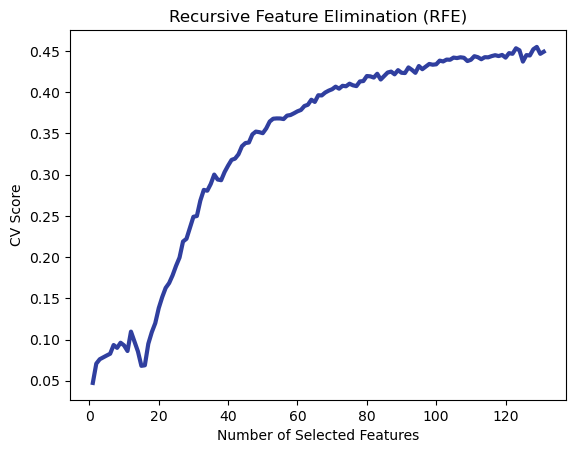

The optimal number of features: 129


In [138]:
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()
print("The optimal number of features: {}".format(rfecv.n_features_))

Make a new DataFrame called "X_rfe" that contains selected features.

In [139]:
reduced_df_cor = np.array(reduced_df_cor, dtype=np.float32)

In [140]:
X_rfe = reduced_df_cor[:, rfecv.support_]

In [141]:
X_rfe.shape

(12054, 129)

In [142]:
estimator.fit(X_rfe, y_tr)

GradientBoostingRegressor(learning_rate=0.04, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [143]:
y_pred_CV_GBR = cross_val_predict(estimator, X_rfe, y_tr, cv=cv, n_jobs=-1)

In [144]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.46

In [145]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.5

In [218]:
reduced_df_cor=x_tr_const_and_nearcont.drop(to_drop, axis=1)

In [244]:
feature_idx = rfecv.get_support()
feature_name_rfecv = reduced_df_cor.columns[feature_idx]
feature_name_rfecv

Index(['Bit_1', 'Bit_4', 'Bit_8', 'Bit_15', 'Bit_25', 'Bit_31', 'Bit_33',
       'Bit_36', 'Bit_41', 'Bit_42',
       ...
       'Bit_961', 'Bit_967', 'Bit_980', 'Bit_997', 'Bit_999', 'Bit_1009',
       'Bit_1010', 'Bit_1016', 'Bit_1017', 'Bit_1019'],
      dtype='object', length=191)

In [ ]:
df = pd.DataFrame(data[1:], columns=feature_name_rfecv)

In [248]:
type(feature_name_rfecv)

pandas.core.indexes.base.Index

In [255]:
from pathlib import Path

In [260]:
urls=list(feature_name_rfecv)

In [258]:
path = Path('feature_name_rfecv_MF.txt')

In [259]:
path.write_text('\n'.join(urls))

1510

# SVM model building and validation

In [146]:
from sklearn.svm import SVR

In [147]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [148]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [149]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [150]:
svm.fit(X_rfe, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [151]:
svm.best_params_
best_svm = svm.best_estimator_

In [152]:
svm.best_params_

{'C': 1, 'gamma': 0.1}

In [153]:
y_pred_CV_svm = cross_val_predict(best_svm, X_rfe, y_tr, cv=cv)

In [154]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.48

In [155]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.49